In [92]:
from ramandecompy import spectrafit
from ramandecompy import dataprep
import h5py
import matplotlib.pyplot as plt
import numpy as np

from scipy import interpolate
from lmfit.models import PseudoVoigtModel

In [94]:
hdf5_file = '../ramandecompy/tests/test_files/dataprep_experiment.hdf5'
key = '300C/25s'
hdf5 = h5py.File(hdf5_file, 'r+')
x_data = list(hdf5['{}/{}'.format(key, 'wavenumber')])
y_data = list(hdf5['{}/{}'.format(key, 'counts')])

In [36]:
# del hdf5['300C/25s']
hdf5.close()

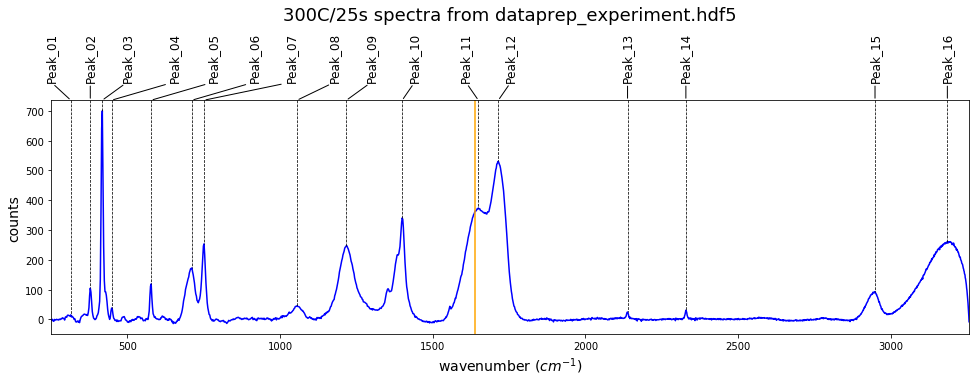

In [99]:
fig, ax = dataprep.plot_fit(hdf5_file, key)
plt.axvline(x=1640, color='orange')

develop a new function that will refit the data using the original fit plus a dictionary of custom locations. The dictionary elements with either be integer wavenumbers, or string Peak_#s, followed by how many peaks should be applied to that location.

In [ ]:
# extract peak center and height locations from hdf5
peaks = []
for _,peak in enumerate(list(hdf5[key])[:-2]):
    peaks.append((list(hdf5['{}/{}'.format(key, peak)])[2], list(hdf5['{}/{}'.format(key, peak)])[5]))
peaks

In [ ]:
from scipy import interpolate
# specify a peaks to add manually
peak_loc = [1350, 1385]
# interpolate data
comp_int = interpolate.interp1d(x_data, y_data, kind='cubic')
# iterate through peak_loc
peaks_add = []
for _,guess in enumerate(peak_loc):
    height = comp_int(int(guess))
    peaks_add.append((int(guess), int(height)))
peaks_add

In [ ]:
from lmfit.models import PseudoVoigtModel

mod, pars = spectrafit.set_params(peaks)
peak_list = []
for i, _ in enumerate(peaks_add):
    prefix = 'p{}_'.format(i+1+len(peaks))
    peak = PseudoVoigtModel(prefix=prefix)
    pars.update(peak.make_params())
    pars[prefix+'center'].set(peaks_add[i][0], vary=True, min=(peaks_add[i][0]-10), max=(peaks_add[i][0]+10))
    pars[prefix+'height'].set(min=0.1*peaks_add[i][1])
    pars[prefix+'sigma'].set(100, min=1, max=150)
    pars[prefix+'amplitude'].set(min=0)
    peak_list.append(peak)
    mod = mod + peak_list[i]

In [ ]:
out = spectrafit.model_fit(x_data, y_data, mod, pars, report=True)

In [ ]:
import numpy as np
x_data = np.asarray(x_data)
y_data = np.asarray(y_data)

spectrafit.plot_fit(x_data, y_data, out, plot_components=True)

now to explore a bit with loosening the sensitivity of the automatic functions to detect too many peaks and then remove those with too small of an area to contribute

In [ ]:
# peaks = spectrafit.peak_detect(x_data, y_data, height=(0.02*max(y_data)), prominence=(0.01*max(y_data)))[0]
# len(peaks)
# extract peak center and height locations from hdf5
peaks = []
for _,peak in enumerate(list(hdf5[key])[:-2]):
    peaks.append((list(hdf5['{}/{}'.format(key, peak)])[2], list(hdf5['{}/{}'.format(key, peak)])[5]))
peaks

In [ ]:
mod, pars = spectrafit.set_params(peaks)
out = spectrafit.model_fit(x_data, y_data, mod, pars)
spectrafit.plot_fit(x_data, y_data, out, plot_components=True)

In [35]:
dataprep.add_experiment(hdf5_file, 'ramandecompy/tests/test_files/FA_3.6wt__300C_25s.csv')

In [31]:
def build_custom_model(x_data, y_data, peaks, peaks_add, plot_fit):
    # add new list of peaks to model
    mod, pars = spectrafit.set_params(peaks)
    peak_list = []
    for i, _ in enumerate(peaks_add):
        prefix = 'p{}_'.format(i+1+len(peaks))
        peak = PseudoVoigtModel(prefix=prefix)
        pars.update(peak.make_params())
        pars[prefix+'center'].set(peaks_add[i][0], vary=True, min=(peaks_add[i][0]-10), max=(peaks_add[i][0]+10))
        pars[prefix+'height'].set(min=0.1*peaks_add[i][1])
        pars[prefix+'sigma'].set(100, min=1, max=150)
        pars[prefix+'amplitude'].set(min=0)
        peak_list.append(peak)
        mod = mod + peak_list[i] 
    # run the fit
    out = spectrafit.model_fit(x_data, y_data, mod, pars)
    # plot_fit option
    if plot_fit is True:
        spectrafit.plot_fit(x_data, y_data, out, plot_components=True)
    else:
        pass
    # save fit data
    fit_result = spectrafit.export_fit_data(x_data, out)
    # add 'user_added' label as 8th term to user added peaks
    for i in range(len(peaks), len(fit_result)):
        fit_result[i].append('user_added')
    # sort peaks by center location for saving
    fit_result = sorted(fit_result, key=lambda x: int(x[2]))
    return fit_result

    
def adjust_peaks(hdf5_file, key, add_list, drop_list=None, plot_fit=False):
    """docstring"""
    # open hdf5_file
    hdf5 = h5py.File(hdf5_file, 'r+')
    # extract raw x-y data
    x_data = np.asarray(hdf5['{}/{}'.format(key, 'wavenumber')])
    y_data = np.asarray(hdf5['{}/{}'.format(key, 'counts')])
    # extract peak center and height locations from hdf5
    peaks = []
    for _,peak in enumerate(list(hdf5[key])[:-2]):
        peaks.append((list(hdf5['{}/{}'.format(key, peak)])[2], list(hdf5['{}/{}'.format(key, peak)])[5]))
    # drop desired tuples from peaks
    if drop_list is not None:
        drop_index = []
        for _,name in enumerate(drop_list):
            drop_index.append(int(name.split('_')[-1])-1)
        for i,index in enumerate(drop_index):
            peaks.pop(index-i)      
    else:
        pass
    # interpolate data
    comp_int = interpolate.interp1d(x_data, y_data, kind='cubic')
    # iterate through add_list
    peaks_add = []
    for _,guess in enumerate(add_list):
        height = comp_int(int(guess))
        peaks_add.append((int(guess), int(height)))
    # build new model
    fit_result = build_custom_model(x_data, y_data, peaks, peaks_add, plot_fit)
    # delete old fit data
    del hdf5['300C/25s']
    # write data to .hdf5
    hdf5['{}/wavenumber'.format(key)] = x_data
    hdf5['{}/counts'.format(key)] = y_data
    for i, _ in enumerate(fit_result):
        if len(fit_result[i]) == 7:
            if i < 9:
                hdf5['{}/Peak_0{}'.format(key, i+1)] = fit_result[i][:6]
            else:
                hdf5['{}/Peak_{}'.format(key, i+1)] = fit_result[i][:6]
        elif len(fit_result[i]) == 8:
            if i < 9:
                hdf5['{}/Peak_0{}*'.format(key, i+1)] = fit_result[i][:6]
            else:
                hdf5['{}/Peak_{}*'.format(key, i+1)] = fit_result[i][:6]
        else:
            print('fit_result for Peak_{} contains an inappropriate number of values'.format(i))
    hdf5.close()

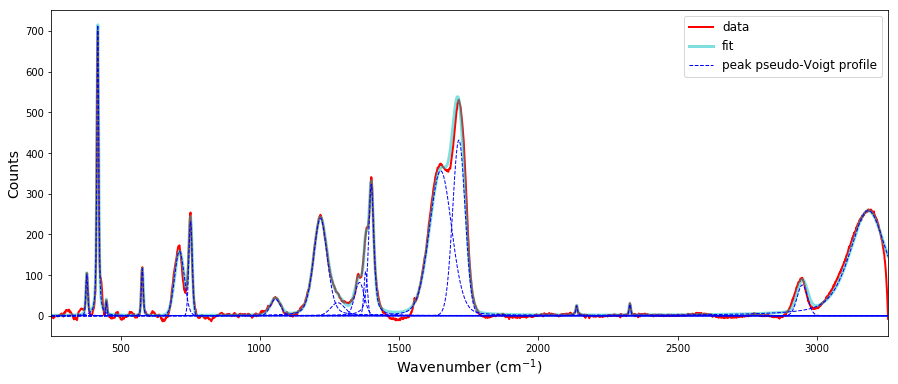

In [32]:
add_list = [1270, 1350, 1385]
# add_list = [1270]
drop_list = ['Peak_01']
hdf5_file = 'ramandecompy/tests/test_files/dataprep_experiment.hdf5'
key = '300C/25s'

adjust_peaks(hdf5_file, key, add_list, drop_list, plot_fit=True)

**** ramandecompy/tests/test_files/dataprep_experiment.hdf5 ****
300C
|    25s
|    |    Peak_01
|    |    Peak_02
|    |    Peak_03
|    |    Peak_04
|    |    Peak_05
|    |    Peak_06
|    |    Peak_07
|    |    Peak_08
|    |    Peak_09*
|    |    Peak_10*
|    |    Peak_11*
|    |    Peak_12
|    |    Peak_13
|    |    Peak_14
|    |    Peak_15
|    |    Peak_16
|    |    Peak_17
|    |    Peak_18
|    |    counts
|    |    wavenumber


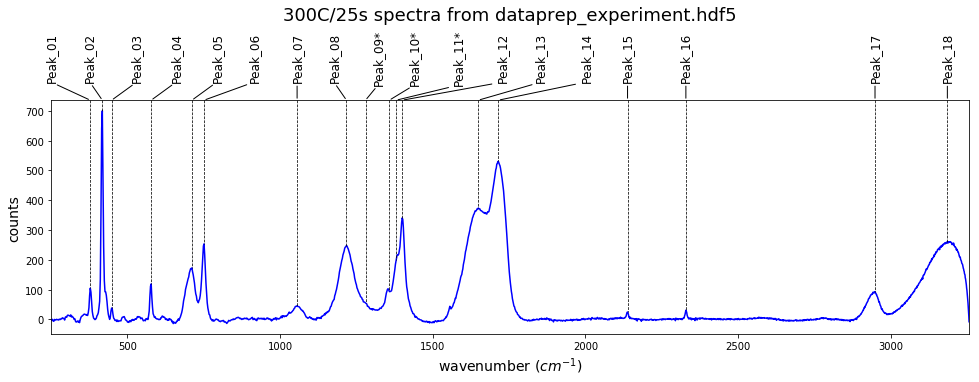

In [33]:
hdf5_file = 'ramandecompy/tests/test_files/dataprep_experiment.hdf5'
dataprep.view_hdf5(hdf5_file)
fig, ax = dataprep.plot_fit(hdf5_file, key)

In [18]:
foo = [1,2,3,4,5,6,7]
foo[:6]

[1, 2, 3, 4, 5, 6]

# New peak fitting based off number of peaks only test

In [3]:
hdf5 = h5py.File('../examples/cal_example.hdf5', 'r')
dataprep.view_hdf5('../examples/cal_example.hdf5')

**** ../examples/cal_example.hdf5 ****
Carbon Monoxide
|    Peak_1
|    x
|    y
Hydrogen
|    Peak_1
|    Peak_2
|    Peak_3
|    Peak_4
|    x
|    y
Methane
|    Peak_1
|    x
|    y


In [86]:
x_data = np.asarray(list(hdf5['Hydrogen/x']))
y_data = np.asarray(list(hdf5['Hydrogen/y']))

peaks = 2
x_range = np.arange(int(min(x_data)), int(max(x_data)), 1)
peak_dist = len(x_range)/(peaks+1)
centers = np.arange(int(min(x_data)), int(max(x_data)), peak_dist)[1:]
heights = [0.5*max(y_data)]*len(centers)
peaks = list(zip(centers, heights))
peaks

[(1252.0, 938.7967736665098), (2254.0, 938.7967736665098)]

In [87]:
peak_list = []
for i, _ in enumerate(peaks):
    prefix = 'p{}_'.format(i+1)
    peak = PseudoVoigtModel(prefix=prefix)
    if i == 0:
        pars = peak.make_params()
    else:
        pars.update(peak.make_params())
    pars[prefix+'center'].set(peaks[i][0], min=min(x_data), max=max(x_data))
    pars[prefix+'height'].set(min=0.1*peaks[i][1])
    pars[prefix+'sigma'].set(100, min=1, max=150)
    pars[prefix+'amplitude'].set(50000, min=0)
    peak_list.append(peak)
    if i == 0:
        mod = peak_list[i]
    else:
        mod = mod + peak_list[i]

In [88]:
out = spectrafit.model_fit(x_data, y_data, mod, pars, report=False)

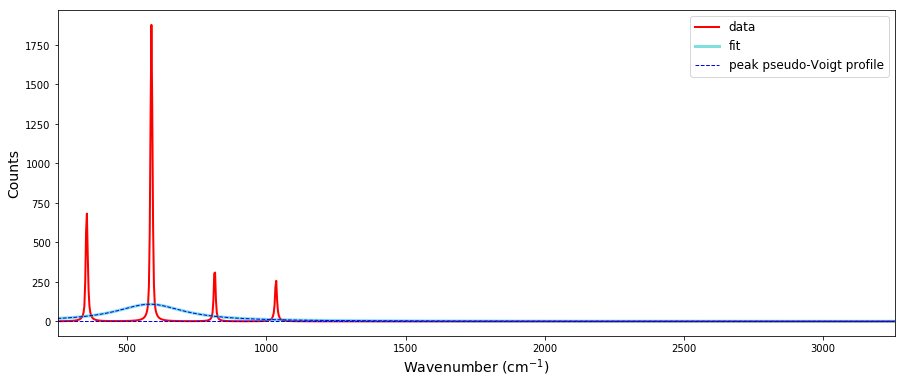

In [89]:
spectrafit.plot_fit(x_data, y_data, out, plot_components=True)

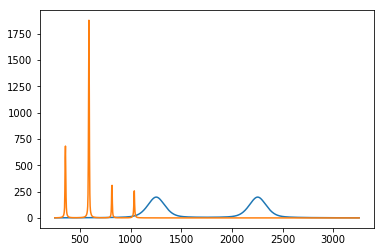

In [90]:
plt.plot(x_data, out.init_fit)
plt.plot(x_data, y_data)

### I don't think this method will work